# Fáza 2 - Predspracovanie údajov

__Autori:__ Dávid Penťa, Samuel Bernát
__Percentuálny podiel práce:__ 50% / 50%

V tejto fáze sa od Vás očakáva že realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada (csv alebo tsv), kde jedno pozorovanie je opísané jedným riadkom.
- scikit-learn vie len numerické dáta, takže treba niečo spraviť s nenumerickými dátami.
- Replikovateľnosť predspracovania na trénovacej a testovacej množine dát, aby ste mohli
zopakovať predspracovanie viackrát podľa Vašej potreby (iteratívne).

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát, je možné že treba realizovať EDA opakovane podľa Vašej potreby. Bodovanie znovu (EDA) nebudeme, zmeny ale dokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa potreby.

In [35]:
import copy
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import  KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier

In [36]:
measurements_file = "data/measurements.csv"
measurements_data = pd.read_csv(measurements_file, sep='\t')
measurements_data_drop = pd.read_csv(measurements_file, sep='\t')
measurements_data_med = pd.read_csv(measurements_file, sep='\t')
measurements_data_avg = pd.read_csv(measurements_file, sep='\t')
measurements_data_knn = pd.read_csv(measurements_file, sep='\t')

stations_file = "data/stations.csv"
stations_data = pd.read_csv(stations_file, sep='\t')
stations_data_drop = pd.read_csv(stations_file, sep='\t')

In [37]:
column_names_measurements = []
column_names_stations = []
column_names = []

for column_name in list(stations_data.columns.values):
    column_names_stations.append(column_name)
    column_names.append(column_name)

for column_name in list(measurements_data.columns.values):
    column_names_measurements.append(column_name)
    column_names.append(column_name)

chemical_names = copy.deepcopy(column_names_measurements)

for i in ['warning', 'latitude', 'longitude']:
    chemical_names.remove(i)

## 1. Integrácia a čistenie dát
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte.
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie ako napr.
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### Čistenie dát z prvého odovzdania

In [38]:
stations_data["QoS"] = np.where(stations_data["QoS"] == "accep", "acceptable", stations_data["QoS"])
stations_data["QoS"] = np.where(stations_data["QoS"] == "maitennce", "maintenance", stations_data["QoS"])

stations_data['revision'] = stations_data['revision'].apply(lambda x: pd.Timestamp(x).timestamp())

stations_data['latitude'] = stations_data['latitude'].round(5)
stations_data['longitude'] = stations_data['longitude'].round(5)

stations_data["station"] = np.where(stations_data["station"] == "T‚Äôaebaek", "Taebaek", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "'Ali Sabieh", "Ali Sabieh", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Oktyabr‚Äôskiy", "Oktyabrsk", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Roslavl‚Äô", "Roslavl", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Dyat‚Äôkovo", "Dyatkovo", stations_data["station"])

### Chýbajúce hodnoty
Prvou použitou technikou odstránim pozorovania s chýbajúcimi údajmi (v tvare Nan).

In [39]:
measurement_num_rows = measurements_data.shape[0]
stations_num_rows = stations_data.shape[0]

measurements_data_drop.dropna(inplace=True)
stations_data_drop.dropna(inplace=True)

print("Percento vymazanych zaznamov z tabulky measurments: ", round(100-(100*(measurements_data_drop.shape[0]/measurement_num_rows)),4), "%")
print("Percento vymazanych zaznamov z tabulky stations: ", round(100-(100*(stations_data_drop.shape[0]/stations_num_rows)),4), "%")

measurements_data_drop.describe()

Percento vymazanych zaznamov z tabulky measurments:  5.9165 %
Percento vymazanych zaznamov z tabulky stations:  0.0901 %


,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
count,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000,11354.000000
mean,8.297913,7.782754,42.142838,1.613470,49.554778,47.498913,7.773308,15.204602,7.770848,7.775716,28.443169,13.775611,7.266905,7.010714,1125.270499,9.075318,0.596794,8.034244
std,1.586617,1.007698,12.395932,3.143773,12.196605,12.834764,1.945376,10.073561,0.996985,1.000381,22.776860,71.189175,1.833217,1.770922,43.251921,1.203203,0.490563,1.907293
min,3.477580,3.785100,0.000000,0.000000,0.000000,0.000000,0.550720,-24.172230,3.949570,4.001820,-44.396720,-123.026210,0.000000,0.329060,1050.022380,4.368180,0.000000,1.301390
25%,7.027690,7.100788,33.941005,0.297710,41.330123,38.887642,6.366695,8.354100,7.106990,7.104933,14.466930,-48.592780,5.966068,5.781708,1087.708007,8.271968,0.000000,6.628567
50%,8.457380,7.767315,42.197775,0.725260,49.555435,47.423935,7.817690,15.197145,7.773285,7.774805,35.680300,11.412000,7.225500,6.884135,1125.199780,9.062300,1.000000,8.305245
75%,9.479685,8.461037,50.514885,1.753273,57.645525,56.207077,9.201617,22.047202,8.435765,8.447817,43.962220,73.083330,8.587992,8.187268,1163.112545,9.864650,1.000000,9.322580
max,13.607100,11.439650,100.000000,100.000000,100.000000,100.000000,13.789240,50.762920,11.295470,11.520660,68.798330,178.004170,13.631490,13.728730,1199.996620,13.469870,1.000000,16.087840


Druhou technikou nahradím v datasete chýbajúce hodnoty mediánom daného stĺpca.

In [40]:
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
imp_med.fit(measurements_data_med)
measurements_data_med = pd.DataFrame(imp_med.transform(measurements_data_med), columns=column_names_measurements).copy()
measurements_data_med.describe()

,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
count,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000
mean,8.294489,7.782765,42.194258,1.605458,49.560786,47.506914,7.770921,15.171284,7.765312,7.776136,28.493755,13.608787,7.264333,7.010393,1125.316351,9.079251,0.596536,8.034139
std,1.582484,1.005658,12.381187,3.130227,12.163983,12.801651,1.939392,10.052994,0.993560,0.997730,22.778624,71.152879,1.831837,1.766672,43.279694,1.198674,0.490613,1.905132
min,3.477580,3.785100,0.000000,0.000000,0.000000,0.000000,0.550720,-24.172230,3.949570,4.001820,-44.396720,-123.026210,0.000000,0.329060,1050.022380,4.368180,0.000000,1.301390
25%,7.030123,7.103887,34.003975,0.298475,41.365918,38.915295,6.373473,8.393662,7.107250,7.109282,14.466930,-48.627890,5.967420,5.790360,1087.724245,8.284300,0.000000,6.631518
50%,8.447240,7.774410,42.259170,0.721640,49.618510,47.467040,7.815850,15.138540,7.769190,7.775255,35.729170,11.377030,7.223635,6.884770,1125.244655,9.070310,1.000000,8.300640
75%,9.474255,8.458172,50.492013,1.745340,57.621423,56.158727,9.186530,21.976050,8.427058,8.441475,43.962220,73.071713,8.582648,8.175323,1163.181182,9.864900,1.000000,9.319650
max,13.607100,11.439650,100.000000,100.000000,100.000000,100.000000,13.789240,50.762920,11.295470,11.520660,68.798330,178.004170,13.631490,13.728730,1199.996620,13.469870,1.000000,16.087840


Treťou technikou nahradím v datasete chýbajúce hodnoty priemerom daného stĺpca.

In [41]:
imp_avg = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_avg.fit(measurements_data_avg)
measurements_data_avg = pd.DataFrame(imp_med.transform(measurements_data_avg), columns=column_names_measurements).copy()
measurements_data_avg.describe()

,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
count,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000
mean,8.294489,7.782765,42.194258,1.605458,49.560786,47.506914,7.770921,15.171284,7.765312,7.776136,28.493755,13.608787,7.264333,7.010393,1125.316351,9.079251,0.596536,8.034139
std,1.582484,1.005658,12.381187,3.130227,12.163983,12.801651,1.939392,10.052994,0.993560,0.997730,22.778624,71.152879,1.831837,1.766672,43.279694,1.198674,0.490613,1.905132
min,3.477580,3.785100,0.000000,0.000000,0.000000,0.000000,0.550720,-24.172230,3.949570,4.001820,-44.396720,-123.026210,0.000000,0.329060,1050.022380,4.368180,0.000000,1.301390
25%,7.030123,7.103887,34.003975,0.298475,41.365918,38.915295,6.373473,8.393662,7.107250,7.109282,14.466930,-48.627890,5.967420,5.790360,1087.724245,8.284300,0.000000,6.631518
50%,8.447240,7.774410,42.259170,0.721640,49.618510,47.467040,7.815850,15.138540,7.769190,7.775255,35.729170,11.377030,7.223635,6.884770,1125.244655,9.070310,1.000000,8.300640
75%,9.474255,8.458172,50.492013,1.745340,57.621423,56.158727,9.186530,21.976050,8.427058,8.441475,43.962220,73.071713,8.582648,8.175323,1163.181182,9.864900,1.000000,9.319650
max,13.607100,11.439650,100.000000,100.000000,100.000000,100.000000,13.789240,50.762920,11.295470,11.520660,68.798330,178.004170,13.631490,13.728730,1199.996620,13.469870,1.000000,16.087840


Poslednou technikou nahradím v datasete chýbajúce hodnoty hodnotou vypočítanou metódou kNN, s nastavením na 5 susedov.

In [42]:
imp_knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imp_knn.fit(measurements_data_knn)
measurements_data_knn = pd.DataFrame(imp_knn.transform(measurements_data_knn), columns=column_names_measurements).copy()
measurements_data_knn.describe()

,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
count,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.000000,12068.00000
mean,8.293041,7.783289,42.193653,1.608454,49.562573,47.504945,7.770729,15.171842,7.765296,7.776124,28.493755,13.608787,7.264386,7.010764,1125.316351,9.079520,0.594862,8.03251
std,1.583050,1.006403,12.384928,3.131057,12.168564,12.807139,1.940022,10.058885,0.993994,0.998095,22.778624,71.152879,1.832661,1.767312,43.279694,1.199084,0.490142,1.90595
min,3.477580,3.785100,0.000000,0.000000,0.000000,0.000000,0.550720,-24.172230,3.949570,4.001820,-44.396720,-123.026210,0.000000,0.329060,1050.022380,4.368180,0.000000,1.30139
25%,7.028090,7.102588,34.003975,0.298382,41.362268,38.904710,6.373473,8.380242,7.106092,7.108187,14.466930,-48.627890,5.966477,5.788800,1087.724245,8.283910,0.000000,6.62953
50%,8.445410,7.775525,42.258735,0.723835,49.624605,47.465335,7.815485,15.137920,7.769190,7.775255,35.729170,11.377030,7.224010,6.886755,1125.244655,9.071360,1.000000,8.29867
75%,9.474255,8.458578,50.496670,1.748880,57.626440,56.164907,9.189730,21.991880,8.428028,8.443180,43.962220,73.071713,8.582975,8.177280,1163.181182,9.866423,1.000000,9.31965
max,13.607100,11.439650,100.000000,100.000000,100.000000,100.000000,13.789240,50.762920,11.295470,11.520660,68.798330,178.004170,13.631490,13.728730,1199.996620,13.469870,1.000000,16.08784


### Outlier detection
Použitím prvej techniky odstránim vychýlené pozorovania z datasetu.

In [43]:
measurements_data_out_drop = measurements_data_knn.copy(deep=True)
measurements_data_out = measurements_data_knn.copy(deep=True)

measurements_data_out.shape

(12068, 18)

In [44]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return a[(a > upper) | (a < lower)]

def get_lower_and_upper(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return [lower, upper]

In [45]:
measurements_outliers = {}
measurements_lower_and_upper = {}

for column in chemical_names:
    measurements_outliers[column] = identify_outliers(measurements_data_out[column])
    measurements_lower_and_upper[column] = get_lower_and_upper(measurements_data_out[column])

outliers = pd.DataFrame(data=measurements_outliers)

In [46]:
# drop
measurements_data_out_drop = measurements_data_out_drop.drop(outliers.index)
measurements_data_out_drop

,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
0,6.33846,6.61796,44.89247,0.22646,37.51693,39.50358,6.93304,18.26344,7.24953,8.60015,53.95278,32.86389,5.35805,6.00130,1136.95323,10.59506,1.0,9.243910
1,7.90785,8.15426,50.02976,0.40716,49.00037,41.15652,10.00080,18.84880,7.08920,8.16071,9.33370,122.86370,6.22960,7.40706,1104.78569,7.82884,0.0,6.673818
2,6.78253,7.32578,50.42226,0.27588,53.51533,61.03352,6.41183,13.61953,8.25103,8.93315,58.63667,59.80222,5.16975,5.07507,1148.76311,10.04912,1.0,8.736400
4,9.16375,7.12481,48.82457,1.32986,32.22006,46.82387,11.63958,12.48813,6.26932,7.81736,32.54044,-82.90375,5.96896,8.44913,1099.39295,9.40919,0.0,4.808340
5,7.04390,7.96828,56.56011,0.31311,56.18221,41.18541,10.42120,12.74538,8.75889,7.43447,37.73604,-120.93549,8.58263,6.89506,1050.67737,7.20484,0.0,6.002150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12063,9.19695,7.92486,59.23293,1.40122,45.11566,62.02799,10.79559,13.34113,6.78988,8.45646,45.53069,9.40531,9.75596,6.93416,1149.48262,9.42584,1.0,9.227870
12064,10.27894,6.99879,48.01565,3.83467,44.55588,31.89886,9.42860,5.17211,8.98672,7.14161,34.14251,-118.25508,8.29618,4.34404,1106.63191,11.02506,1.0,11.227980
12065,7.03277,7.83287,35.07280,0.30955,35.87540,55.96849,7.07224,12.89596,6.43694,9.15356,46.75451,33.34864,6.44011,7.08258,1194.68756,10.35400,1.0,5.763930
12066,8.21318,7.03138,50.31096,0.54791,44.57737,38.07472,9.37725,0.68008,7.38683,7.91926,33.43443,-5.22126,9.26976,6.81885,1095.25573,8.53529,1.0,8.199650


Použitím druhej techniky nahradím vychýlené hodnoty hraničnými hodnotami rozdelenia.

In [47]:
for column in chemical_names:
    for u in range(len(outliers[column])):
        if outliers[column].iloc[u] <= measurements_lower_and_upper[column][0]:
            outliers[column].iloc[u] = measurements_lower_and_upper[column][0]
        else:
            outliers[column].iloc[u] = measurements_lower_and_upper[column][1]

new_column_names=['latitude', 'longitude', 'warning']
outliers = pd.DataFrame(outliers, columns=column_names_measurements)

outliers = outliers.fillna(measurements_data_out)

measurements_data_out.loc[outliers.index] = np.nan
measurements_data_out = measurements_data_out.combine_first(outliers)

measurements_data_out

,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
0,6.338460,6.617960,44.892470,0.226460,37.516930,39.503580,6.933040,18.263440,7.24953,8.600150,53.95278,32.86389,5.358050,6.00130,1136.953230,10.595060,1.0,9.243910
1,7.907850,8.154260,50.029760,0.407160,49.000370,41.156520,10.000800,18.848800,7.08920,8.160710,9.33370,122.86370,6.229600,7.40706,1104.785690,7.828840,0.0,6.673818
2,6.782530,7.325780,50.422260,0.275880,53.515330,61.033520,6.411830,13.619530,8.25103,8.933150,58.63667,59.80222,5.169750,5.07507,1148.763110,10.049120,1.0,8.736400
3,13.143502,10.492563,75.235713,3.924626,82.022699,82.055204,13.414116,42.409336,5.12319,5.105699,12.95629,78.27539,12.507721,11.76000,1276.366589,12.240191,1.0,13.354830
4,9.163750,7.124810,48.824570,1.329860,32.220060,46.823870,11.639580,12.488130,6.26932,7.817360,32.54044,-82.90375,5.968960,8.44913,1099.392950,9.409190,0.0,4.808340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12063,9.196950,7.924860,59.232930,1.401220,45.115660,62.027990,10.795590,13.341130,6.78988,8.456460,45.53069,9.40531,9.755960,6.93416,1149.482620,9.425840,1.0,9.227870
12064,10.278940,6.998790,48.015650,3.834670,44.555880,31.898860,9.428600,5.172110,8.98672,7.141610,34.14251,-118.25508,8.296180,4.34404,1106.631910,11.025060,1.0,11.227980
12065,7.032770,7.832870,35.072800,0.309550,35.875400,55.968490,7.072240,12.895960,6.43694,9.153560,46.75451,33.34864,6.440110,7.08258,1194.687560,10.354000,1.0,5.763930
12066,8.213180,7.031380,50.310960,0.547910,44.577370,38.074720,9.377250,0.680080,7.38683,7.919260,33.43443,-5.22126,9.269760,6.81885,1095.255730,8.535290,1.0,8.199650


Dataset measurements_data_out_drop reprezentuje použitie techniky odstránenia hraničných hodnôt, measurements_data_out reprezentuje nahradenie daných hodnôt.

### Spojenie tabuliek

Pre spojenie tabuliek musíme najprv vymazať duplicitne data v tabuľke stations a ponechať len najnovšie revisions. Keďže sa v názve staníc často vyskytovali chyby, na zistenie toho či sa jedná o duplicitnú stanicu používame zemepisnú šírku a dĺžku.

In [48]:
stations_data = stations_data.groupby(by=['latitude', 'longitude'], group_keys=False).apply(lambda x: x.loc[x['revision']==x['revision'].max()])
stations_data

,QoS,station,code,latitude,longitude,revision
661,maintenance,Timaru,NZ,-44.39672,171.25364,1.663805e+09
954,excellent,Gisborne,NZ,-38.65333,178.00417,1.640650e+09
8,excellent,Frankston South,AU,-38.16604,145.13643,1.645920e+09
606,good,Wheelers Hill,AU,-37.90000,145.18333,1.549498e+09
582,maintenance,Carnegie,AU,-37.88333,145.06667,1.401581e+09
...,...,...,...,...,...,...
1057,average,Petrozavodsk,RU,61.78491,34.34691,1.497744e+09
984,average,Severodvinsk,RU,64.56350,39.83020,1.609546e+09
103,average,Tornio,FI,65.84811,24.14662,1.649722e+09
617,acceptable,Aykhal,RU,65.93381,111.48340,1.657325e+09


In [49]:
df = pd.merge(stations_data, measurements_data_knn, on=['latitude', 'longitude'], how='inner')
df

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,O3,TEMP,NOx,SO2,NH3,CH4,PRES,PM2.5,warning,PAHs
0,maintenance,Timaru,NZ,-44.39672,171.25364,1.663805e+09,10.16138,7.24444,18.78853,3.338450,...,10.80652,-3.80863,6.88023,6.54374,10.230840,7.476368,1108.21536,9.53627,1.0,10.42692
1,maintenance,Timaru,NZ,-44.39672,171.25364,1.663805e+09,6.64445,8.33981,73.17595,0.190250,...,5.85957,14.22938,8.15735,9.19272,7.979420,5.982630,1154.63743,9.38508,1.0,10.43616
2,maintenance,Timaru,NZ,-44.39672,171.25364,1.663805e+09,6.89275,8.13628,11.46454,0.285670,...,6.41710,9.10943,6.89405,7.57661,5.804080,4.869190,1063.56320,9.02577,1.0,8.62441
3,maintenance,Timaru,NZ,-44.39672,171.25364,1.663805e+09,9.86941,8.88509,36.11418,2.514050,...,7.54692,16.98578,5.64041,7.93513,6.885130,8.956690,1151.65894,9.46945,0.0,6.52934
4,maintenance,Timaru,NZ,-44.39672,171.25364,1.663805e+09,6.72281,8.28767,44.44024,0.243170,...,9.54334,10.76937,8.62563,5.10649,9.989580,10.378540,1115.78763,7.57212,1.0,4.93176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12063,maintenance,Harstad,NO,68.79833,16.54165,1.587341e+09,9.19440,6.80827,47.81687,1.398010,...,8.55221,26.12673,7.92770,6.94602,8.826000,7.194580,1176.12597,9.96565,0.0,5.54772
12064,maintenance,Harstad,NO,68.79833,16.54165,1.587341e+09,7.12185,7.93095,41.17582,0.441114,...,4.98680,4.68508,8.32018,8.17031,4.670900,6.468580,1176.58702,9.80836,0.0,8.34844
12065,maintenance,Harstad,NO,68.79833,16.54165,1.587341e+09,7.99575,6.61106,53.83363,0.354470,...,10.12581,11.38475,7.16576,9.14704,6.312296,6.551420,1166.38584,7.58430,0.0,5.32555
12066,maintenance,Harstad,NO,68.79833,16.54165,1.587341e+09,6.72743,8.57558,21.47758,0.233000,...,6.24639,33.92485,7.30071,8.70480,5.495440,6.841870,1069.63443,8.44546,1.0,8.46121


### Opis každého atribútu numerickým formátom

Na opis každého atribútu numerickým formátom sme použili LabelEncoder(), čo každú unikátnu hodnotu v stĺpci nahradí jej ID.

In [50]:
le = LabelEncoder()
le.fit(df['station'])
df['station'] = le.transform(df['station'])

le.fit(df['code'])
df['code'] = le.transform(df['code'])

le.fit(df['QoS'])
df['QoS'] = le.transform(df['QoS'])

df

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,O3,TEMP,NOx,SO2,NH3,CH4,PRES,PM2.5,warning,PAHs
0,5,585,80,-44.39672,171.25364,1.663805e+09,10.16138,7.24444,18.78853,3.338450,...,10.80652,-3.80863,6.88023,6.54374,10.230840,7.476368,1108.21536,9.53627,1.0,10.42692
1,5,585,80,-44.39672,171.25364,1.663805e+09,6.64445,8.33981,73.17595,0.190250,...,5.85957,14.22938,8.15735,9.19272,7.979420,5.982630,1154.63743,9.38508,1.0,10.43616
2,5,585,80,-44.39672,171.25364,1.663805e+09,6.89275,8.13628,11.46454,0.285670,...,6.41710,9.10943,6.89405,7.57661,5.804080,4.869190,1063.56320,9.02577,1.0,8.62441
3,5,585,80,-44.39672,171.25364,1.663805e+09,9.86941,8.88509,36.11418,2.514050,...,7.54692,16.98578,5.64041,7.93513,6.885130,8.956690,1151.65894,9.46945,0.0,6.52934
4,5,585,80,-44.39672,171.25364,1.663805e+09,6.72281,8.28767,44.44024,0.243170,...,9.54334,10.76937,8.62563,5.10649,9.989580,10.378540,1115.78763,7.57212,1.0,4.93176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12063,5,224,79,68.79833,16.54165,1.587341e+09,9.19440,6.80827,47.81687,1.398010,...,8.55221,26.12673,7.92770,6.94602,8.826000,7.194580,1176.12597,9.96565,0.0,5.54772
12064,5,224,79,68.79833,16.54165,1.587341e+09,7.12185,7.93095,41.17582,0.441114,...,4.98680,4.68508,8.32018,8.17031,4.670900,6.468580,1176.58702,9.80836,0.0,8.34844
12065,5,224,79,68.79833,16.54165,1.587341e+09,7.99575,6.61106,53.83363,0.354470,...,10.12581,11.38475,7.16576,9.14704,6.312296,6.551420,1166.38584,7.58430,0.0,5.32555
12066,5,224,79,68.79833,16.54165,1.587341e+09,6.72743,8.57558,21.47758,0.233000,...,6.24639,33.92485,7.30071,8.70480,5.495440,6.841870,1069.63443,8.44546,1.0,8.46121


### Uloženie upravenej dátovej sady do .csv súboru

In [51]:
df.to_csv('output.csv', index=False)

## 2. Realizácia predspracovania dát
- Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
- Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

V prvom rade si transformované dáta rozdelíme na testovaciu a trénovaciu množinu. Rozhodli sme sa pre pomer častí 0.7 pre časť dát na učenie a 0.3 pre dáta na testovanie. Vďaka tomuto pomeru je časť na učenie dostatočne veľká pre uspokojivé výsledky, zároveň časť na testovanie nie je zanedbateľná.


In [52]:
training_data, testing_data = train_test_split(measurements_data_out_drop, test_size=0.3, random_state=25)

print("Pocet vzoriek na trenovanie: ", training_data.shape[0])
print("Pocet vzoriek na testovanie: ", testing_data.shape[0])

Pocet vzoriek na trenovanie:  7168
Pocet vzoriek na testovanie:  3072


V rámci transformácie dát pre strojové učenie sme už v predošlých krokoch pomocou metódy škálovania, konkrétne normalizácie dát odstránili záznamy s hodnotami Nan, dáta sme dávali do rovnakého formátu a tvaru a opravovali nekorektne (nejednotne) zapísané dáta v datasetoch. Na grafoch kde sme porovnávali výsledky a správanie sa dát po odstránení záznamov s chýbajúcimi údajmi, nahradenie chýbajúcich údajov mediánom, priemerom a metódou kNN sme dospeli k záveru, že najvýhodnejší a zároveň najkorektnejší spôsob je jednoducho odstránenie záznamov, pretože sa nejednalo o veľkú vzorku v rámci našich datasetov ako celkov. Zároveň sme nenumerické hodnoty zmenili pomocou nami vymysleného kLúča na numerické - napríklad pre sĺpec Qos v datasete sme pre každý zo stavov priradili číslo od 1 do 5.

## 4. Replikovateľnosť predspracovania
- Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovupoužiť na predspracovanie testovacej množiny (pomocou funkcie/í)
- Očakáva sa aj využitie možnosti sklearn.pipeline

Funkcia merge vyčistí dáta v tabuľke stations a spoji tabuľku stations s tabuľkou measures.

In [53]:
def merge(station_data, measurement_data):
    station_data["QoS"] = np.where(station_data["QoS"] == "accep", "acceptable", station_data["QoS"])
    station_data["QoS"] = np.where(station_data["QoS"] == "maitennce", "maintenance", station_data["QoS"])

    station_data['revision'] = station_data['revision'].apply(lambda x: pd.Timestamp(x).timestamp())

    station_data['latitude'] = station_data['latitude'].round(5)
    station_data['longitude'] = station_data['longitude'].round(5)

    station_data["station"] = np.where(station_data["station"] == "T‚Äôaebaek", "Taebaek", station_data["station"])
    station_data["station"] = np.where(station_data["station"] == "'Ali Sabieh", "Ali Sabieh", station_data["station"])
    station_data["station"] = np.where(station_data["station"] == "Oktyabr‚Äôskiy", "Oktyabrsk", station_data["station"])
    station_data["station"] = np.where(station_data["station"] == "Roslavl‚Äô", "Roslavl", station_data["station"])
    station_data["station"] = np.where(station_data["station"] == "Dyat‚Äôkovo", "Dyatkovo", station_data["station"])

    station_data = station_data.groupby(by=['latitude', 'longitude'], group_keys=False).apply(lambda x: x.loc[x['revision']==x['revision'].max()])
    result_table = pd.merge(station_data, measurement_data, on=['latitude', 'longitude'], how='inner')

    return result_table

Funkcia split rozdelí dáta na trénovacie a testovacie.

In [54]:
def split(data):
    column_names_ = []
    for column_name_ in list(data.columns.values):
        column_names_.append(column_name_)

    column_names_.remove('warning')

    X_train, X_test, y_train, y_test = train_test_split(data[column_names_], data['warning'])

    return X_train, X_test, y_train, y_test

Funkcia power_transform spraví yeo-johnson power transform pre zvolený stĺpec.

In [55]:
def power_transform(X, column_name):
    data = X[column_name].values
    data = data.reshape((len(data),1))

    data_trans = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(data)
    X[column_name] = data_trans

Funkcia transform slúži na testovacie aj trénovacie dáta. Funkcia nahradí dáta numerickými, zavolá power_transform pre potrebné riadky, nahradí NaN hodnoti pomocou KNNImputer, štandardizuje stĺpce pomocou StandardScaler a uloží dáto do .csv súboru.

In [56]:
def transform(X, y=None):
    le = LabelEncoder()
    le.fit(X['station'])
    X['station'] = le.transform(X['station'])

    le.fit(X['code'])
    X['code'] = le.transform(X['code'])

    le.fit(X['QoS'])
    X['QoS'] = le.transform(X['QoS'])

    column_names_t = []

    for column_name_t in list(X.columns.values):
        column_names_t.append(column_name_t)

    chemical_names_t = copy.deepcopy(column_names_t)

    passthroughs_t = ['QoS', 'station', 'code', 'latitude', 'longitude', 'revision']

    for passthrough in passthroughs_t:
        chemical_names_t.remove(passthrough)

    if y is not None: # ak y nie je None potom mame trenovacie data
        column_names_t.append('warning')
        passthroughs_t.append('warning')
        X['warning'] = y
        X.dropna(subset=['warning'], inplace=True) # trenovacie data bez warning mozeme vyhodit


    column_names_t = passthroughs_t + chemical_names_t

    for i in chemical_names_t:
        if abs(X[i].skew()) > 1.5:
            power_transform(X, i)

    pipe = make_pipeline(
        KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'),
        # Normalizer(),
        StandardScaler()
    )

    ct = ColumnTransformer([('passthrough', 'passthrough', passthroughs_t), ('num_transformer', pipe, chemical_names_t)])

    pipeline = Pipeline([('column_transformer', ct)])

    pipeline.fit(X)
    transformed_df = pd.DataFrame(pipeline.transform(X), columns=column_names_t).copy()

    X.to_csv('output.csv', index=False)

    if y is None:
        return transformed_df
    else:
        column_names_t.remove('warning')
        return transformed_df[column_names_t], transformed_df['warning']

In [57]:
d = merge(pd.read_csv(stations_file, sep='\t'), pd.read_csv(measurements_file, sep='\t'))
X_train, X_test, y_train, y_test = split(d)

X_train, y_train = transform(X_train, y_train)
X_train

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,H2CO,O3,TEMP,NOx,SO2,NH3,CH4,PRES,PM2.5,PAHs
0,3.0,430.0,108.0,2.41669,30.98551,1.614470e+09,-0.708488,-0.263848,-0.577033,-0.889291,...,-0.292153,-0.858313,0.666269,0.836141,0.539441,-0.021675,-1.119228,-0.457288,0.404999,0.513120
1,1.0,584.0,46.0,18.65297,-72.09391,1.579997e+09,0.089516,-0.541805,0.227454,-0.185619,...,1.022008,1.060644,0.863037,-0.665575,3.177250,0.918871,0.416274,-0.417718,0.818713,-0.376927
2,3.0,142.0,50.0,14.46693,75.92694,1.619222e+09,-1.135036,-0.009608,1.012075,-1.111357,...,1.594646,0.306508,-0.256415,0.593878,1.458169,-0.890008,0.639828,-0.172003,2.411447,0.490706
3,2.0,503.0,109.0,26.18924,-98.15529,1.659658e+09,0.932962,1.646990,-0.417451,1.098134,...,1.615248,0.859348,-0.255102,-0.107356,0.240225,0.639265,-0.807781,0.963948,1.497905,0.998718
4,3.0,51.0,16.0,0.49113,29.47306,1.660522e+09,-0.834847,-0.423779,-0.100281,-1.122799,...,-0.655954,1.152713,-0.779451,2.713106,-0.490237,1.491356,1.456771,0.036951,-1.267911,-1.173663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,2.0,503.0,109.0,26.18924,-98.15529,1.659658e+09,-0.262555,-0.679843,0.783594,-0.532247,...,-0.800784,-1.744346,-0.509968,0.596540,1.508464,-0.485333,-0.014607,-0.379150,-0.783115,0.796640
9008,3.0,620.0,37.0,55.82737,-4.05730,1.652832e+09,0.437699,-0.209651,1.918225,0.428126,...,-0.225529,-1.034793,2.008290,-1.898108,0.049478,-0.737550,-0.178997,-0.151684,-0.810403,-0.899819
9009,4.0,43.0,50.0,22.10194,85.37752,1.647475e+09,0.315158,0.244852,-0.634457,0.252108,...,-0.145049,0.744018,0.182626,0.973499,-0.764155,0.878257,-0.442700,-0.013918,-0.181780,0.541367
9010,1.0,163.0,57.0,36.82167,128.63083,1.625789e+09,1.064578,-0.668896,-0.282046,1.247165,...,-0.072996,-1.029597,-1.739227,0.349632,-0.529237,0.312257,-1.834891,1.092223,-1.445125,-2.043867


Kontrola či sme dobre transformovali dáta pre strojové učenie.

In [58]:
classif = OneVsRestClassifier(estimator=LinearRegression())
classif.fit(X_train, y_train)

X_test, y_test = transform(X_test, y_test)
classif.score(X_test, y_test)

0.9238190286094478

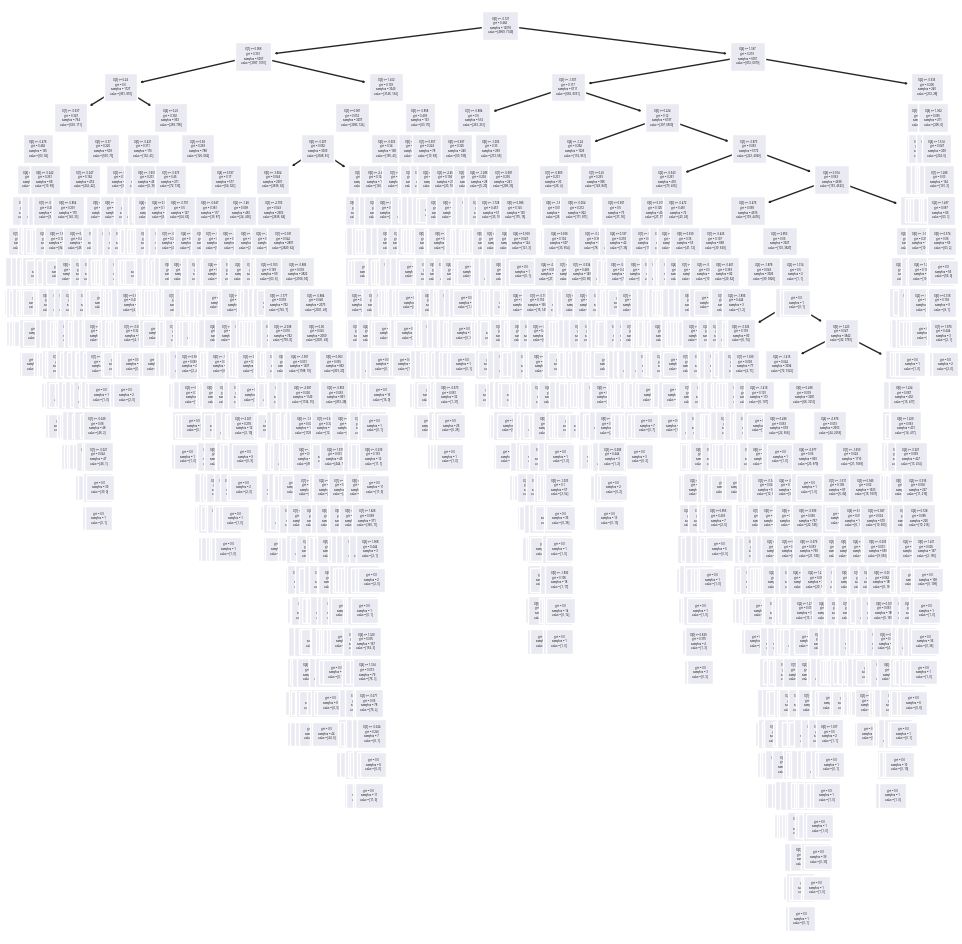

In [62]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

d = merge(pd.read_csv(stations_file, sep='\t'), pd.read_csv(measurements_file, sep='\t'))
X_train, X_test, y_train, y_test = split(d)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


X, y = transform(X, y)

X = X[['PAHs', 'PM10', 'C2H3NO5', 'NH3', 'CH4', 'PM2.5']]

clf = clf.fit(X, y)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
tree.plot_tree(clf, fontsize=2)
plt.savefig('tree_high_dpi', dpi=100)

## 3. Výber atribútov pre strojové učenie
- Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “warning”. Zoradíte tie atribúty v poradí podľa dôležitosti.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

Funkcia chose_informative_attributes_for_ml zoradí štatisticky signifikantné atribúty podľa Pearson correlation coefficient.

In [ ]:
def chose_informative_attributes_for_ml(X, y):
    info_attributes = []
    for column_name in list(X.columns.values):
        (r, p) = pearsonr(y, X[column_name])
        if p < 0.05:
            info_attributes.append([column_name, abs(r), p])

    array = sorted(info_attributes, key=itemgetter(1))

    sorted_info_attributes = []
    for i in range(len(array)):
        sorted_info_attributes.append([i + 1, array[len(array) - i - 1][0], array[len(array) - i - 1][1], array[len(array) - i - 1][2]])

    for row in sorted_info_attributes:
        print("{: >0} {: >10} {:.5f} {:.5f}".format(*row))

In [ ]:
d = merge(pd.read_csv(stations_file, sep='\t'), pd.read_csv(measurements_file, sep='\t'))
X_train, X_test, y_train, y_test = split(d)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

X, y = transform(X, y)
chose_informative_attributes_for_ml(X, y)